# Multi-Agent Workflows + RAG - LangGraph

Today we'll be looking at an example of a Multi-Agent workflow that's powered by LangGraph, LCEL, and more!

We're going to be, more specifically, looking at a "heirarchical agent teams" from the [AutoGen: Enabling Next-Gen LLM
Applications via Multi-Agent Conversation](https://arxiv.org/pdf/2308.08155) paper.

This will be the final "graph" of our system:

![image](https://i.imgur.com/r2NIOVB.png)

> NOTE: Each Agent (1 & 2) will actually *itself* be a multi-agent graph!

It's important to keep in mind that the actual implementation will be constructed of 3 separate graphs, the final one having 2 graphs as nodes! LangGraph is a heckuva tool!



# 🤝 BREAKOUT ROOM #1

## Dependencies

Since we'll be relying on OpenAI's suite of models to power our agents today, we'll want to provide our OpenAI API Key.

We're also going to be using the Tavily search tool - so we'll want to provide that API key as well!

Instruction for how to obtain the Tavily API key can be found:

1. [Tavily API Key](https://app.tavily.com/sign-in)



In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

## Task 1: Simple LangGraph RAG

Now that we have our dependencies set-up - let's create a simple RAG graph that works over our Loan PDFs from previous sessions.

> NOTE: While this particular example is very straight forward - you can "plug in" any complexity of chain you desire as a node in a LangGraph.

## Retrieval

The 'R' in 'RAG' - this is, at this point, fairly straightforward!

#### Data Collection and Processing

A classic first step, at this point, let's grab our desired document!

In [3]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

Now we can chunk it down to size!

In [4]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

Now we've successfully split our single PDF into...

In [5]:
len(loan_knowledge_chunks)

375

documents!

#### Embedding Model and Vector Store

Now that we have our chunked document - lets create a vector store, which will first require us to create an embedding model to get the vector representations of our text!

We'll use OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) model - as it's cheap, and performant.

In [7]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

Now we can create our QDrant backed vector store!

In [8]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=loan_knowledge_chunks,
    embedding=embedding_model,
    location=":memory:"
)

Let's make sure we can access it as a retriever.

In [9]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

### Augmented

Now that we have our retrieval process set-up, we need to set up our "augmentation" process - AKA a prompt template.

In [10]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

### Generation

Last, but certainly not least, let's put the 'G' in 'RAG' by adding our generator - in this case, we can rely on OpenAI's [`gpt-4o-mini`](https://platform.openai.com/docs/models/gpt-4o-mini) model!

In [11]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

### RAG - Retrieval Augmented Generation

All that's left to do is combine our R, A, and G into a single graph - and we're off!

In [12]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

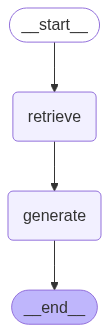

In [13]:
rag_graph

Let's test this out and make sure it works.

In [15]:
rag_graph.invoke({"question" : "What is the maximum loan amount?"})

{'question': 'What is the maximum loan amount?',
 'context': [Document(metadata={'producer': 'GPL Ghostscript 10.00.0', 'creator': 'wkhtmltopdf 0.12.6', 'creationdate': "D:20250605165703Z00'00'", 'source': 'data/The_Direct_Loan_Program.pdf', 'file_path': 'data/The_Direct_Loan_Program.pdf', 'total_pages': 71, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250605165703Z00'00'", 'trapped': '', 'modDate': "D:20250605165703Z00'00'", 'creationDate': "D:20250605165703Z00'00'", 'page': 69, '_id': '80352f10b103420f905c5ce9e66abf7e', '_collection_name': 'cacac4dd2922487ea7425f3c453f93d6'}, page_content='program. Therefore, the maximum loan amount the student may receive for the program at School B (for the\nabbreviated loan period and any subsequent loan period combined) is a total of $1,815, not more than $1,155 of\nwhich may be subsidized (the prorated loan limits for the program). If the student receives the maximum prorated\nloan limit for the 

### RAG Limitation

Notice how we're hard-coding our data, while this is simply meant to be an illustrative example - you could easily extend this to work with any provied paper or document in order to have a more dynamic system.

For now, we'll stick with this single hard-coded example in order to keep complexity down in an already very long notebook!

##### 🏗️ Activity #1 (Bonus Marks)

Allow the system to dynamically fetch Arxiv papers instead of hard coding them.

> HINT: Tuesday's assignment will be very useful here.

## Task 2: Helper Functions for Agent Graphs

We'll be using a number of agents, nodes, and supervisors in the rest of the notebook - and so it will help to have a collection of useful helper functions that we can leverage to make our lives easier going forward.

Let's start with the most simple one!

#### Import Wall

Here's a wall of imports we'll be needing going forward!

In [16]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Helper

Since we're going to be wrapping each of our agents into a node - it will help to have an easy way to create the node!

In [17]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

### Agent Creation Helper Function

Since we know we'll need to create agents to populate our agent nodes, let's use a helper function for that as well!

Notice a few things:

1. We have a standard suffix to append to our system messages for each agent to handle the tool calling and boilerplate prompting.
2. Each agent has its our scratchpad.
3. We're relying on OpenAI's function-calling API for tool selection
4. Each agent is its own executor.

In [35]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

### Supervisor Helper Function

Finally, we need a "supervisor" that decides and routes tasks to specific agents.

Since each "team" will have a collection of potential agents - this "supervisor" will act as an "intelligent" router to make sure that the right agent is selected for the right task.

Notice that, at the end of the day, this "supervisor" is simply directing who acts next - or if the state is considered "done".

In [36]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

## Task 3: Research Team - A LangGraph for Researching Loan Policy

Now that we have our RAG chain set-up and some awesome helper functions, we want to create a LangGraph related to researching a specific topic, in this case: Loans!

We're going to start by equipping our Research Team with a few tools:

1. Tavily Search - aka "Google", for the most up to date information possible.
2. Our RAG chain - specific and high quality information about our topic.

Let's create those tools now!

### Tool Creation

As you can see below, some tools already come pre-packaged ready to use!

In [37]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

Creating a custom tool, however, is very straightforward.

> NOTE: You *must* include a docstring, as that is what the LLM will consider when deciding when to use this tool.

In [38]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about student loan policies"""
  return rag_graph.invoke({"question" : query})

> NOTE: We could just as easily use the LCEL chain directly, since nodes can be LCEL objects - but creating a tool helps explain the tool creation process at the same time.

### Research Team State

Since we're using LangGraph - we're going to need state!

Let's look at how we've created our state below.

In [39]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

Notice how we've used `messages`, `team_members`, and `next`.

These states will help us understand:

1. What we've done so far (`messages`)
2. Which team members we have access to (`team_members`)
3. Which team member is up next! (`next`)

### Research Team LLM

We'll be using `gpt-4o-mini` today. This LLM is going to be doing a lot of reasoning - but we also want to keep our costs down, so we'll use a lightweight; but powerful, model!

In [40]:
llm = ChatOpenAI(model="gpt-4o-mini")

##### ❓ Question #1:

Why is a "powerful" LLM important for this use-case?

What tasks must our Agent perform that make it such that the LLM's reasoning capability is a potential limiter?

### Research Team Agents & Nodes

Now we can use our helper functions to create our agent nodes, with their related tools.

Let's start with our search agent node.

#### Research Team: Search Agent

We're going to give our agent access to the Tavily tool, power it with our GPT-4o Mini model, and then create its node - and name it `Search`.

In [41]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

#### Research Team: RAG Agent Node

Now we can wrap our LCEL RAG pipeline in an agent node as well, using the LCEL RAG pipeline as the tool, as created above.

In [42]:
research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on the student loan policies",
)
research_node = functools.partial(agent_node, agent=research_agent, name="LoanRetriever")

### Research Team Supervisor Agent

Notice that we're not yet creating our supervisor *node*, simply the agent here.

Also notice how we need to provide a few extra pieces of information - including which tools we're using.

> NOTE: It's important to use the *exact* tool name, as that is how the LLM will reference the tool. Also, it's important that your tool name is all a single alphanumeric string!



In [43]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, LoanRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "LoanRetriever"],
)

### Research Team Graph Creation

Now that we have our research team agent nodes created, and our supervisor agent - let's finally construct our graph!

We'll start by creating our base graph from our state, and then adding the nodes/agent we've created as nodes on our LangGraph.

In [44]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("LoanRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

Now we can define our edges - include our conditional edge from our supervisor to our agent nodes.

Notice how we're always routing our agent nodes back to our supervisor!

In [45]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("LoanRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "LoanRetriever": "LoanRetriever", "FINISH": END},
)

Now we can set our supervisor node as the entry point, and compile our graph!

In [46]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

#### Display Graph

In [30]:
import nest_asyncio
nest_asyncio.apply()

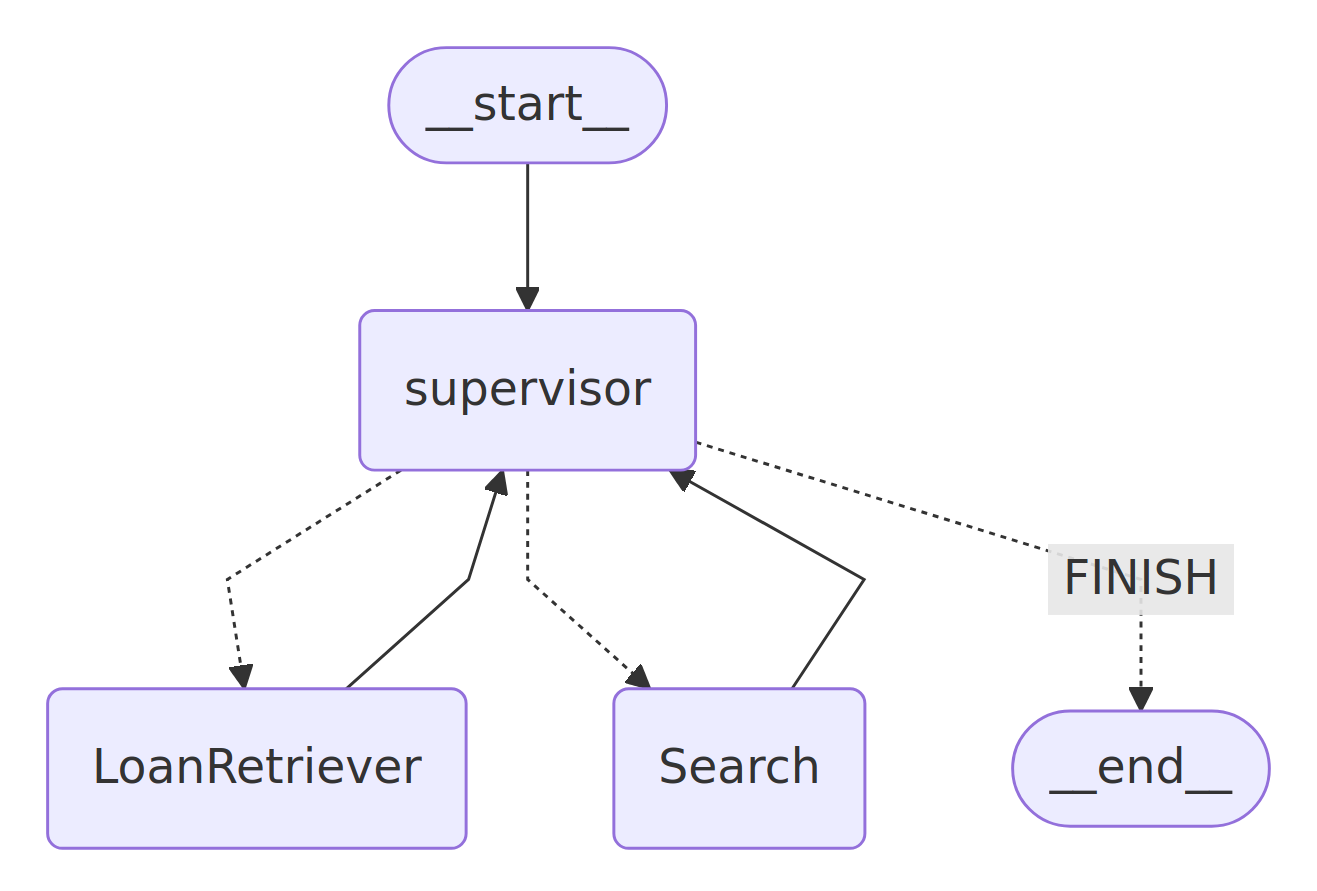

In [47]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

The next part is key - since we need to "wrap" our LangGraph in order for it to be compatible in the following steps - let's create an LCEL chain out of it!

This allows us to "broadcast" messages down to our Research Team LangGraph!

In [48]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

Now, finally, we can take it for a spin!

In [51]:
for s in research_chain.stream(
    "What is the maximum student loan in 2025?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'LoanRetriever'}}
---
{'LoanRetriever': {'messages': [HumanMessage(content='The maximum student loan amounts for 2025 are as follows:\n\n- **For dependent undergraduate students:** \n  - Total (subsidized and unsubsidized): **$31,000** \n  - Maximum subsidized portion: **$23,000**\n\n- **For independent undergraduate students:** \n  - Total: **$57,500** \n  - Maximum subsidized portion: **$23,000**\n\n- **For graduate and professional students:** \n  - Total: **$138,500** \n  - Maximum subsidized portion: **$65,500**\n\nThese amounts include any loans received for undergraduate study and may vary based on specific circumstances or prorated limits.', additional_kwargs={}, response_metadata={}, name='LoanRetriever')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


##### 🏗️ Activity #2:

Using whatever drawing application you wish - please label the flow above on a diagram of your graph.

##### ❓ Question #2:

How could you make sure your Agent uses specific tools that you wish it to use? Are there any ways to concretely set a flow through tools?

# 🤝 BREAKOUT ROOM #2

## Task 4: Document Writing Team - A LangGraph for Planning, Writing, and Editing a Formal Complaint Response.

Let's run it all back, this time specifically creating tools, agent nodes, and a graph for Planning, Writing, and Editing a Formal Complaint Response!

In [69]:

from langchain_community.document_loaders import CSVLoader

complaint_loader = CSVLoader("data/complaints.csv", content_columns=["Consumer complaint narrative", "Company public response", "Company response to consumer"])
complaints = complaint_loader.load()
complaints[0]

Document(metadata={'source': 'data/complaints.csv', 'row': 0}, page_content="Consumer complaint narrative: The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.\nCompany public response: None\nCompany response to consumer: Closed with explanation")

In [70]:
qdrant_complaint_vectorstore = Qdrant.from_documents(
    documents=complaints,
    embedding=embedding_model,
    location=":memory:"
)

In [71]:
qdrant_complaint_retriever = qdrant_complaint_vectorstore.as_retriever()

### Tool Creation

Let's create some tools that will help us understand, open, work with, and edit documents to our liking!

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool 
def reference_previous_responses(
    query: Annotated[str, "The query to search for in the previous responses."],
) -> Annotated[str, "The previous responses that match the query."]:
    """Search for previous responses that match the query."""
    return qdrant_complaint_retriever.invoke(query)


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

##### 🏗️ Activity #3:

Describe, briefly, what each of these tools is doing in your own words.

### Document Writing State

Just like with our Research Team state - we want to keep track of a few things, however this time - we also want to keep track of which files we've created - so let's add that here!

In [53]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

### Document Writing Prelude Function

Since we have a working directory - we want to be clear about what our current working directory looks like - this helper function will allow us to do that cleanly!

In [54]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

### Document Writing Node Creation



In [ ]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing customer assistance responses.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document, reference_previous_responses],
    ("You are an expert senior researcher tasked with writing a customer assistance outline and"
    " taking notes to craft a customer assistance response.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope. Make sure to use a number of emojis."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Document Writing Team LangGraph Construction

This part is almost exactly the same (with a few extra nodes) as our Research Team LangGraph construction - so we'll leave it as one block!

In [56]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
compiled_authoring_graph = authoring_graph.compile()

#### Display Graph

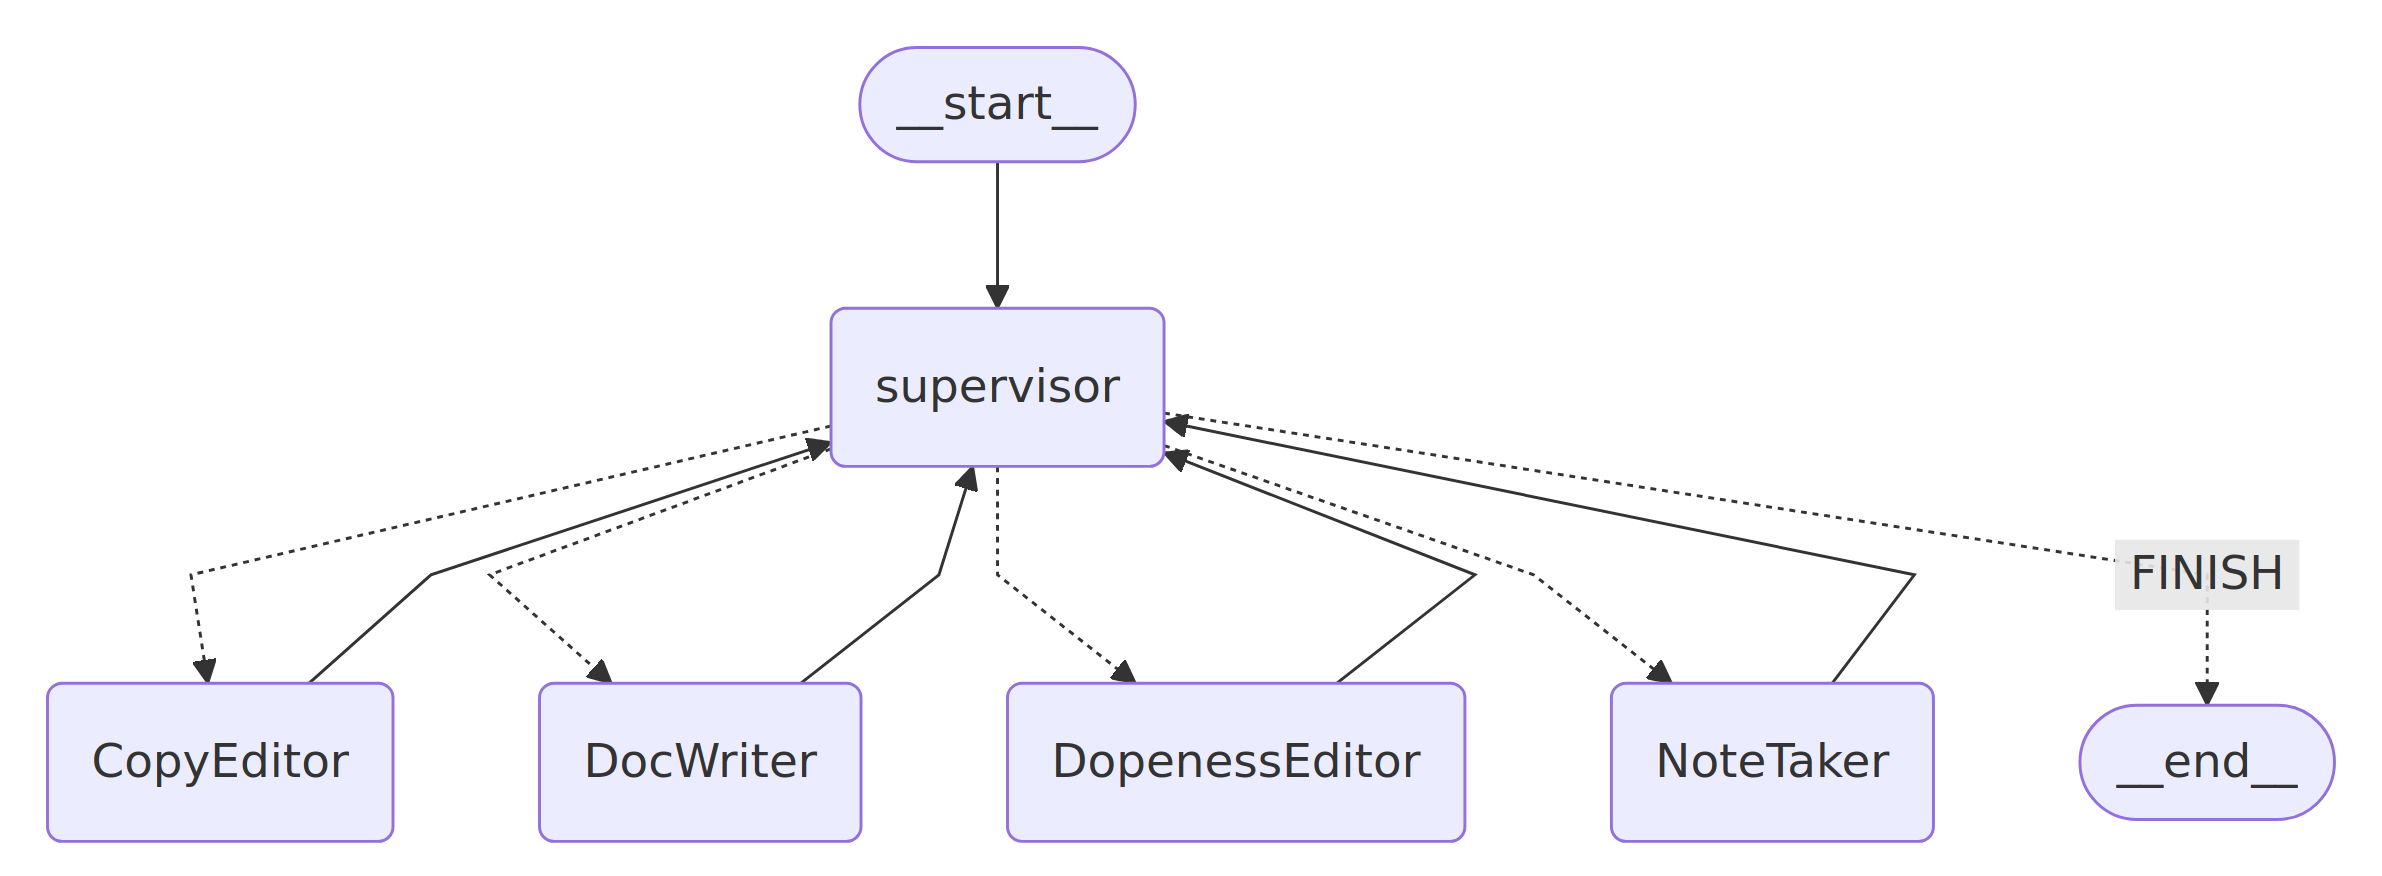

In [57]:
from IPython.display import Image, display

display(
    Image(
        compiled_authoring_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

Just as before - we'll need to create an "interface" between the level above, and our graph.

In [58]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

Now we can test this out!

> NOTE: It is possible you may see an error here - rerun the cell to clear.

In [59]:
for s in authoring_chain.stream(
    "Write a customer assistance response on the positioning of Student Loans as it relates to low income students.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='I have created a customer assistance response regarding the positioning of student loans as it relates to low-income students. You can find the document saved as **Student_Loans_Low_Income_Students_Response.txt**. If you need any further assistance, feel free to ask!', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content="Here is the customer assistance response formulated based on the contents of the document:\n\n---\n\n**Subject: Understanding Student Loans for Low-Income Students**\n\nDear [Customer's Name],\n\nThank you for reaching out to us regarding student loans and the challenges faced by low-income students. We understand that pursuing higher education can be a significant financial burden, particularly for those from low-income backgrounds.\n\nStudent loans can play a crucial rol

## Task 5: Meta-Supervisor and Full Graph

Finally, now that we have our two LangGraph agents (some of which are already multi-agent), we can build a supervisor that sits above all of them!

The final process, surprisingly, is quite straight forward!

Let's jump in!

First off - we'll need to create our supervisor agent node.

In [60]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "Response team"],
)

We'll also create our new state - as well as some methods to help us navigate the new state and the subgraphs.

> NOTE: We only pass the most recent message from the parent graph to the subgraph, and we only extract the most recent message from the subgraph to include in the state of the parent graph.

In [61]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

Next, we'll create our base graph.

Notice how each node we're adding is *AN ENTIRE LANGGRAPH AGENT* (wrapped into an LCEL chain with our helper functions above).

In [62]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Response team", get_last_message | authoring_chain | join_graph)
super_graph.add_node("supervisor", supervisor_node)

Next, we'll create our edges!

This process is completely idenctical to what we've seen before - just addressing the LangGraph subgraph nodes instead of individual nodes.

In [63]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("Response team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Response team": "Response team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
compiled_super_graph = super_graph.compile()

That's it!

Now we can finally use our full agent!

In [64]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a customer assistance response on the positioning of Student Loans as it relates to low income students. First consult the research team. Then make sure you consult the response team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content="Subject: Understanding Student Loans for Low-Income Students\n\nDear [Customer’s Name],\n\nThank you for reaching out with your inquiry about student loans and their implications for low-income students. We understand that navigating financial aid can be challenging, and we are here to support you every step of the way.\n\nStudent loans are instrumental in making higher education more accessible for low-income students. The federal student loan program features two main types: **subsidized** and **unsubsidized loans**. Subsidized loans are especially beneficial for lower-income borrowers, as they do not accrue interest while the student is enrolled in school. For the 2023-2024 academic year, eligible students can borrow up to **$5,500** in subsidized loans, which helps cover educational expenses effectively.\n\nAdditionally, low-income students may also qualify for **Pell Grants**, which

## SAMPLE POST!

Subject: Understanding Student Loans for Low-Income Students

Dear [Customer’s Name],

Thank you for reaching out with your inquiry about student loans and their implications for low-income students. Navigating financial aid can be challenging, and we are here to support you every step of the way.

**Student Loans Overview:**
Student loans play a crucial role in making higher education accessible for low-income students. The federal student loan program features two main types: **subsidized** and **unsubsidized loans**. Subsidized loans are particularly beneficial for lower-income borrowers, as they do not accrue interest while the student is enrolled in school. For the 2023-2024 academic year, eligible students can borrow up to **$5,500** in subsidized loans.

It's also important to consider that low-income students may qualify for **Pell Grants**, which are need-based awards that do not require repayment. For the 2023-2024 academic year, the maximum Pell Grant award is **$7,395**, aimed at alleviating the financial burden faced by low-income families.

**Recent Developments:**
Many colleges and universities are enhancing their financial aid offerings to better support low-income families. For instance, the University of Pennsylvania recently increased financial aid for families earning **$75,000 or less**, ensuring that tuition, fees, housing, and dining costs are fully covered for qualifying students.

The **Free Application for Federal Student Aid (FAFSA)** is a critical step in securing financial aid. For the 2024-2025 academic year, the FAFSA underwent significant changes as part of the FAFSA Simplification Act. Notably, the 2024-2025 FAFSA became available on **December 31, 2023**, which is a shift from the traditional October 1 opening date. Additionally, for the upcoming academic year, the income protection allowance (IPA) – the amount of income excluded from financial aid calculations – will increase significantly, which could positively affect aid eligibility for many students.

To stay updated, the FAFSA for the 2025-2026 academic year will become available on or before **December 1, 2024**. Completing the FAFSA as soon as possible is crucial, as some aid is awarded on a first-come, first-served basis. Ensuring you are aware of these timelines can significantly impact your ability to secure necessary financial support.

If you have more questions about specific types of loans or the financial aid process, please feel free to reach out. We are committed to helping you navigate your educational journey.

Best regards,

[Your Name]  
[Your Position]  
[Your Contact Information]  
[Company Name]  